In [1]:
!pip install imutils==0.5.4
!pip install matplotlib==3.3.4
!pip install opencv-python==4.5.1.48
!pip install scikit-image==0.18.1
!pip install sklearn==0.0

^C


## **Working Aproach**


1.   Convert raw image to HSV format.
2.   Remove noise using Gaussian Blur.
3.   Run k-means clustering on preprocessed image for color based segmentation.
4.   Detect the edges in clustered image.
5.   Find contours in Edge Detection output.
6.   Generate the bounding Box to get the height/width of Paper and Feet.







## **Assumptions**



1.   Printer Paper is used as a reference (Height/Width is known and White background will help in Preprocessing).
2.   Foot should be in center, touching one edge of paper.
3.   Floor color should be different than white.
4.   Image should be clicked from top angle.
5.   Paper should be completely visible in the clicked image.





In [1]:
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage
from imutils import contours
import argparse
import imutils
import cv2
from sklearn.cluster import KMeans
import random as rng

In [3]:
def preprocess(img):

    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    img = cv2.GaussianBlur(img, (9, 9), 0)
    img = img/255

    return img

In [4]:
def plotImage(img):
    
    plt.imshow(img)
    plt.show()

In [5]:
def cropOrig(bRect, oimg):
    # x (Horizontal), y (Vertical Downwards) are start coordinates
    # img.shape[0] = height of image
    # img.shape[1] = width of image

    x,y,w,h = bRect
    
    print(x,y,w,h)
    pcropedImg = oimg[y:y+h,x:x+w]

    x1, y1, w1, h1 = 0, 0, pcropedImg.shape[1], pcropedImg.shape[0]

    y2 = int(h1/10)

    x2 = int(w1/10)

    crop1 = pcropedImg[y1+y2:h1-y2,x1+x2:w1-x2]

    ix, iy, iw, ih = x+x2, y+y2, crop1.shape[1], crop1.shape[0]

    croppedImg = oimg[iy:iy+ih,ix:ix+iw]

    return croppedImg, pcropedImg


In [6]:
def overlayImage(croppedImg, pcropedImg):


    x1, y1, w1, h1 = 0, 0, pcropedImg.shape[1], pcropedImg.shape[0]

    y2 = int(h1/10)

    x2 = int(w1/10)

    new_image = np.zeros((pcropedImg.shape[0], pcropedImg.shape[1], 3), np.uint8)
    new_image[:, 0:pcropedImg.shape[1]] = (255, 0, 0) # (B, G, R)

    new_image[ y1+y2:y1+y2+croppedImg.shape[0], x1+x2:x1+x2+croppedImg.shape[1]] = croppedImg

    return new_image


In [7]:
def kMeans_cluster(img):

    # For clustering the image using k-means, we first need to convert it into a 2-dimensional array
    # (H*W, N) N is channel = 3
    image_2D = img.reshape(img.shape[0]*img.shape[1], img.shape[2])

    kmeans = KMeans(n_clusters=2, random_state=0).fit(image_2D)
    clustOut = kmeans.cluster_centers_[kmeans.labels_]

    # Reshape back the image from 2D to 3D image
    clustered_3D = clustOut.reshape(img.shape[0], img.shape[1], img.shape[2])

    clusteredImg = np.uint8(clustered_3D*255)

    return clusteredImg


In [8]:
def getBoundingBox(img):

    contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)

    contours_poly = [None]*len(contours)
    boundRect = [None]*len(contours)

    for i, c in enumerate(contours):
        contours_poly[i] = cv2.approxPolyDP(c, 3, True)
        boundRect[i] = cv2.boundingRect(contours_poly[i])

    
    return boundRect, contours, contours_poly, img


In [9]:
def drawCnt(bRect, contours, cntPoly, img):

    drawing = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)   


    paperbb = bRect

    for i in range(len(contours)):
      color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
      cv2.drawContours(drawing, cntPoly, i, color)
    cv2.rectangle(drawing, (int(paperbb[0]), int(paperbb[1])), \
              (int(paperbb[0]+paperbb[2]), int(paperbb[1]+paperbb[3])), color, 2)
    
    return drawing

In [10]:
def edgeDetection(clusteredImage):
  edged1 = cv2.Canny(clusteredImage, 0, 255)
  edged = cv2.dilate(edged1, None, iterations=1)
  edged = cv2.erode(edged, None, iterations=1)
  return edged

In [11]:
oimg = imread('data/bhuvan1.jpg')

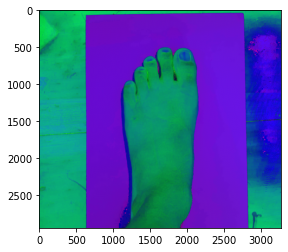

In [12]:
preprocessedOimg = preprocess(oimg)
plotImage(preprocessedOimg)

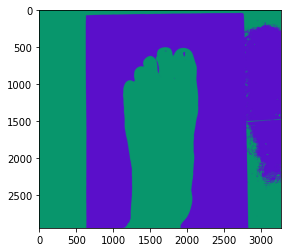

In [13]:
clusteredImg = kMeans_cluster(preprocessedOimg)
plotImage(clusteredImg)

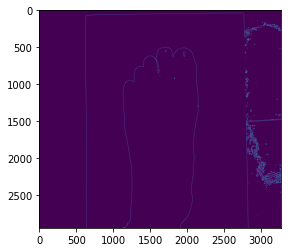

In [14]:
edgedImg = edgeDetection(clusteredImg)
plotImage(edgedImg)

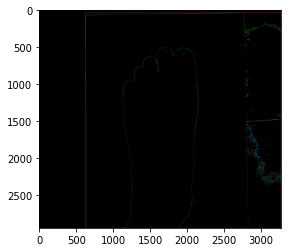

In [15]:
boundRect, contours, contours_poly, img = getBoundingBox(edgedImg)
pdraw = drawCnt(boundRect[1], contours, contours_poly, img)
plotImage(pdraw)


631 38 2645 2909


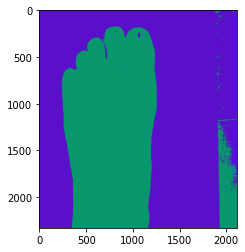

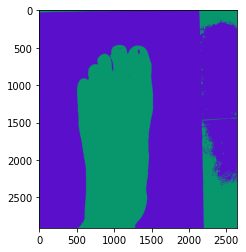

In [16]:
croppedImg, pcropedImg = cropOrig(boundRect[1], clusteredImg)
plotImage(croppedImg)
plotImage(pcropedImg)

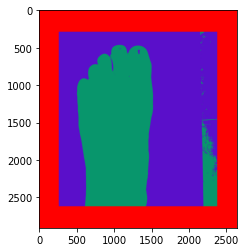

In [17]:
newImg = overlayImage(croppedImg, pcropedImg)
plotImage(newImg)

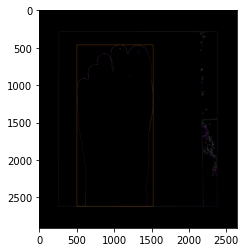

In [18]:
fedged = edgeDetection(newImg)
fboundRect, fcnt, fcntpoly, fimg = getBoundingBox(fedged)
fdraw = drawCnt(fboundRect[2], fcnt, fcntpoly, fimg)
plotImage(fdraw)

In [19]:
def calcFeetSize(pcropedImg, fboundRect):
  x1, y1, w1, h1 = 0, 0, pcropedImg.shape[1], pcropedImg.shape[0]

  y2 = int(h1/10)

  x2 = int(w1/10)

  fh = y2 + fboundRect[2][3]
  fw = x2 + fboundRect[2][2]
  ph = pcropedImg.shape[0]
  pw = pcropedImg.shape[1]

  #print("Feet height: ", fh)
  #print("Feet Width: ", fw)

  #print("Paper height: ", ph)
  #print("Paper Width: ", pw)

  opw = 210
  oph = 297

  ofs = 0.0

  if fw>fh:
    ofs = (oph/pw)*fw
  else :
    ofs = (oph/ph)*fh



  return ofs

In [24]:
print("Feet Size(cm):", calcFeetSize(pcropedImg, fboundRect)/10)

Feet Size(cm): 24.95249226538329
